# New Notebook

Whats this notebook about?

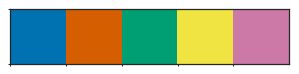

In [19]:
import sys
import os
from glob import glob
import re
from collections import Counter, defaultdict
from operator import itemgetter

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import seaborn as sns

from Bio.SeqIO import parse
from Bio.Seq import Seq
from Bio.SeqUtils import seq1 as seq_edit
from Bio.SeqUtils.CodonUsage import SynonymousCodons as SYN_CODON

import networkx as nx
from g4netx import g4netx
from g4netx.g4netx import build_g_run_graphs, enumerate_subgraphs
from g4netx.g4filter import filter_overlapping

## Default plotting params

%load_ext Cython
%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [270]:
import matplotlib as mpl
print(mpl.__version__)

2.1.0


In [2]:
araport_genes = pd.read_table(
    '../tair10_genome_g4_analysis/araport_genes.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'gene_id', 'score', 'strand',
           'cds_start', 'cds_end', 'color',
           'n_exons', 'exon_sizes', 'exon_starts'],
    usecols=['chrom', 'start', 'end', 'gene_id', 'strand',
             'cds_start', 'cds_end', 'n_exons', 'exon_sizes', 'exon_starts'],
    index_col='gene_id',
    converters={
        'exon_sizes': lambda x: np.array([int(i) for i in x.strip(',').split(',')]),
        'exon_starts': lambda x: np.array([int(i) for i in x.strip(',').split(',')]),
    }
)
araport_genes.exon_starts = araport_genes.exon_starts + araport_genes.start
araport_genes['exon_ends'] = araport_genes.exon_starts + araport_genes.exon_sizes
araport_genes['left_utr_size'] = araport_genes.cds_start - araport_genes.start
araport_genes['right_utr_size'] = araport_genes.end - araport_genes.cds_end
araport_genes['utr5_size'] = [x.left_utr_size if x.strand == '+' else x.right_utr_size
                              for _, x in araport_genes.iterrows()]
araport_genes['log_utr_size'] = np.log(araport_genes.utr5_size + 1)
araport_genes['cds_100bp_start'] = [x.cds_start if x.strand else x.cds_end - 100
                                    for _, x in araport_genes.iterrows()]
araport_genes['cds_100bp_end'] = [x.cds_start + 100 if x.strand else x.cds_end
                                  for _, x in araport_genes.iterrows()]
araport_genes.head()

,chrom,start,end,strand,cds_start,cds_end,n_exons,exon_sizes,exon_starts,exon_ends,left_utr_size,right_utr_size,utr5_size,log_utr_size,cds_100bp_start,cds_100bp_end
gene_id,,,,,,,,,,,,,,,,
AT1G01010,1,3630,5899,+,3759,5630,6,"[283, 281, 120, 390, 153, 461]","[3630, 3995, 4485, 4705, 5173, 5438]","[3913, 4276, 4605, 5095, 5326, 5899]",129,269,129,4.867534,3759,3859
AT1G01020,1,6787,9130,-,7314,8666,7,"[282, 294, 86, 74, 46, 229, 560]","[6787, 7156, 7563, 7761, 7941, 8235, 8570]","[7069, 7450, 7649, 7835, 7987, 8464, 9130]",527,464,464,6.142037,7314,7414
AT1G03987,1,11100,11372,+,11100,11100,1,[272],[11100],[11372],0,272,0,0.000000,11100,11200
AT1G01030,1,11648,13714,-,11863,13334,2,"[1525, 380]","[11648, 13334]","[13173, 13714]",215,380,380,5.942799,11863,11963
AT1G01040,1,23120,31227,+,23518,31079,20,"[1331, 114, 211, 395, 220, 173, 123, 161, 234,...","[23120, 24541, 24751, 25040, 25523, 25824, 260...","[24451, 24655, 24962, 25435, 25743, 25997, 262...",398,148,398,5.988961,23518,23618


In [3]:
araport_genes.reset_index()[
    ['chrom', 'cds_100bp_start', 'cds_100bp_end', 'gene_id', 'n_exons', 'strand']
].to_csv('araport_cds_100bp.bed', sep='\t', header=False, index=False)
!head araport_cds_100bp.bed

1	3759	3859	AT1G01010	6	+
1	7314	7414	AT1G01020	7	-
1	11100	11200	AT1G03987	1	+
1	11863	11963	AT1G01030	2	-
1	23518	23618	AT1G01040	20	+
1	23311	23411	AT1G03993	1	-
1	31381	31481	AT1G01050	10	-
1	32726	32826	AT1G03997	1	+
1	33991	34091	AT1G01060	9	-
1	38897	38997	AT1G01070	5	-


In [4]:
%%bash

source activate jupyter_python3

g4predict intra -tmin 2 -tmax 2 -lmin 1 -lmax 7 -M \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b - |
bedtools intersect -s -c -a araport_cds_100bp.bed -b stdin > araport_cds_100bp.g4count.bed

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': '-',
        'fasta': '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa',
        'filter_overlapping': False,
        'func': <function parse_args.<locals>.intra at 0x7f91b2399bf8>,
        'merge_overlapping': True,
        'write_bed12': True,
        'write_bed6': False}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {'allow_G': 1, 'start': 1, 'stop': 7},
                                    {'allow_G': 1, 'start': 1, 'stop': 7},
                                    {'allow_G': 1, 'start': 1, 'stop': 7}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor': 20},
        'soft_mask': False

In [5]:
araport_genes['g4_cds_100bp'] = pd.read_csv(
    'araport_cds_100bp.g4count.bed', sep='\t',
    names=['chrom', 'cds_100bp_start', 'cds_100bp_end', 'gene_id', 'n_exons', 'strand', 'g4_cds_100bp'],
    usecols=['gene_id', 'g4_cds_100bp'],
    index_col='gene_id'
)
araport_genes.head()

,chrom,start,end,strand,cds_start,cds_end,n_exons,exon_sizes,exon_starts,exon_ends,left_utr_size,right_utr_size,utr5_size,log_utr_size,cds_100bp_start,cds_100bp_end,g4_cds_100bp
gene_id,,,,,,,,,,,,,,,,,
AT1G01010,1,3630,5899,+,3759,5630,6,"[283, 281, 120, 390, 153, 461]","[3630, 3995, 4485, 4705, 5173, 5438]","[3913, 4276, 4605, 5095, 5326, 5899]",129,269,129,4.867534,3759,3859,0
AT1G01020,1,6787,9130,-,7314,8666,7,"[282, 294, 86, 74, 46, 229, 560]","[6787, 7156, 7563, 7761, 7941, 8235, 8570]","[7069, 7450, 7649, 7835, 7987, 8464, 9130]",527,464,464,6.142037,7314,7414,0
AT1G03987,1,11100,11372,+,11100,11100,1,[272],[11100],[11372],0,272,0,0.000000,11100,11200,0
AT1G01030,1,11648,13714,-,11863,13334,2,"[1525, 380]","[11648, 13334]","[13173, 13714]",215,380,380,5.942799,11863,11963,0
AT1G01040,1,23120,31227,+,23518,31079,20,"[1331, 114, 211, 395, 220, 173, 123, 161, 234,...","[23120, 24541, 24751, 25040, 25523, 25824, 260...","[24451, 24655, 24962, 25435, 25743, 25997, 262...",398,148,398,5.988961,23518,23618,0


In [6]:
stats.spearmanr(araport_genes.g4_cds_100bp.astype(bool), araport_genes.utr5_size)

SpearmanrResult(correlation=0.014709457926818633, pvalue=0.0044789690417264515)

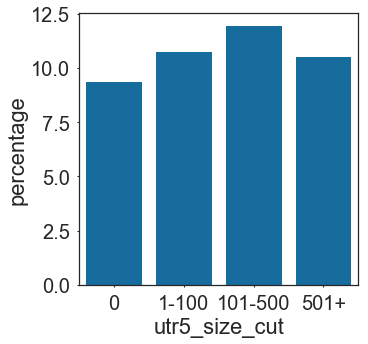

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
araport_genes['utr5_size_cut'] = pd.cut(araport_genes.utr5_size,
                                            [-1, 0, 100, 500, np.inf],
                                            labels=['0', '1-100', '101-500', '501+'])
prop_df = (araport_genes['g4_cds_100bp'].astype(bool)
                                        .groupby(araport_genes['utr5_size_cut'])
                                        .value_counts(normalize=True)
                                        .apply(lambda x: x * 100)
                                        .rename('percentage')
                                        .reset_index())
sns.barplot(
    x='utr5_size_cut',
    y='percentage',
    hue='g4_cds_100bp',
    hue_order=[True],
    data=prop_df,
    ax=ax
)
ax.legend_.remove()
plt.show()

In [8]:
hardcoded = {}

for aa, cdns in SYN_CODON.items():
    aa = seq_edit(aa)
    if aa == 'X':
        aa = '*'
    frames = [[c[x] for c in cdns] for x in range(3)]
    hc = [all([x == f[0] for x in f]) for f in frames]
    hardcoded[aa] = hc
hardcoded['X'] = [False, False, False]

In [9]:
seqs = []
seq_lens = {}
seq_ids = []
with open('/home/matthew/Documents/genomes/tair10/fasta/tair10_cds.fa') as cds:
    for record in parse(cds, 'fasta'):
        if len(str(record.seq)) % 3:
            continue
        seqs.append(str(record.seq))
        seq_ids.append(record.id)
        seq_lens[record.id] = len(str(record.seq))

In [10]:
g4s = []
for seq, name in zip(seqs, seq_ids):
    seq_g4s = []
    for ranges, _, strand in g4netx(seq, 2, 7):
        seq_g4s.append((name, ranges[0][0], ranges[-1][1], np.array([x[:2] for x in ranges]), strand))
    g4s.append(seq_g4s)

In [11]:
g4_networks = []
for seq, name in zip(seqs, seq_ids):
    for graph, strand in build_g_run_graphs(seq, 2, 7):
        start = min(graph.nodes, key=itemgetter(0))[0]
        end = max(graph.nodes, key=itemgetter(1))[1]
        size = 0
        for _ in enumerate_subgraphs(graph, 4):
            size += 1
        if size:
            g4_networks.append((name, graph, start, end, strand, size))

In [12]:
g4_networks = pd.DataFrame(
    g4_networks,
    columns=['transcript_id', 'graph',
             'g4_cluster_start', 'g4_cluster_end', 'strand',
             'size']
)
g4_networks['size_bins'] = pd.cut(
    g4_networks['size'],
    bins=(0, 1, 5, 20, np.inf),
    labels=('1', '2-5', '6-20', '21+')
)
g4_networks['seq_len'] = g4_networks.transcript_id.map(seq_lens)
g4_networks['g4_cluster_mid'] = g4_networks[['g4_cluster_start', 'g4_cluster_end']].sum(1) // 2
bins = []
for _, mid, length in g4_networks[['g4_cluster_end', 'seq_len']].itertuples():
    x = np.linspace(0, length, 100)
    bins.append(np.searchsorted(x, mid))
g4_networks['bin_idx'] = bins
g4_networks.head()

,transcript_id,graph,g4_cluster_start,g4_cluster_end,strand,size,size_bins,seq_len,g4_cluster_mid,bin_idx
0,AT1G51370.2,"((170, 172, False), (177, 179, False), (182, 1...",163,184,+,1,1,1041,173,18
1,AT1G50920.1,"((1232, 1234, False), (1245, 1247, False), (12...",1232,1256,+,3,2-5,2016,1244,62
2,AT1G50920.1,"((1418, 1420, False), (1408, 1410, False), (14...",1407,1426,+,12,6-20,2016,1416,71
3,AT1G44020.1,"((760, 762, False), (752, 754, False), (758, 7...",740,762,+,5,2-5,1734,751,44
4,AT1G44020.1,"((1257, 1259, False), (1256, 1258, False), (12...",1237,1259,-,3,2-5,1734,1248,72


In [13]:
g = g4_networks.loc[g4_networks['size'].idxmax(), 'graph']
ranges = [(None, x[0][0], x[-1][1], None, 1, "+") for x in enumerate_subgraphs(g, 4)]
len(list(filter_overlapping(ranges)))

75

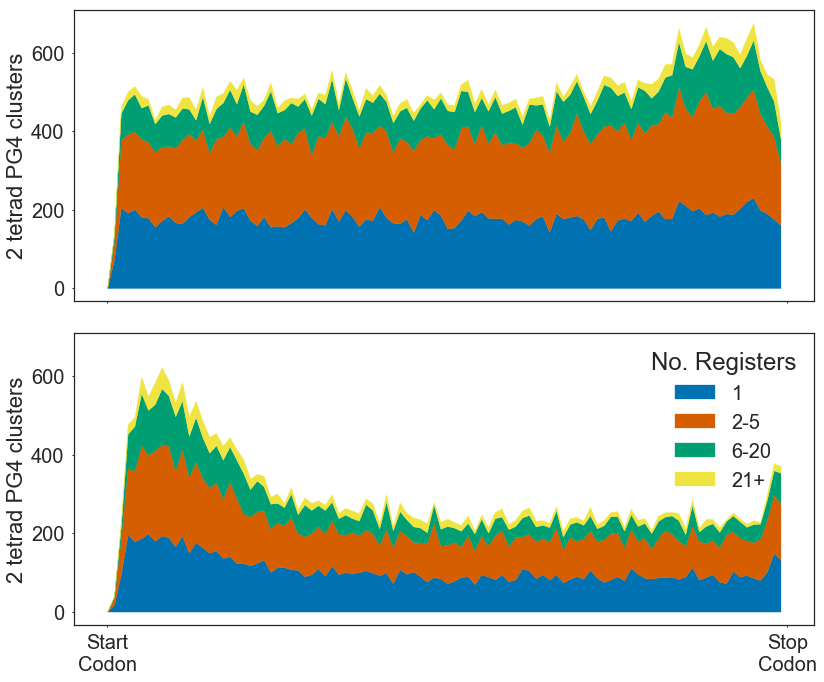

In [14]:
fig, axes = plt.subplots(figsize=(12, 10), nrows=2, sharex=True, sharey=True)
for i, strand in enumerate(('+', '-')):
    all_bins = [np.repeat(0, 100)]
    df_strand = g4_networks[g4_networks.strand == strand]
    axes[i].set_ylabel('2 tetrad PG4 clusters')
    for j in g4_networks.size_bins.cat.categories:
        idx = df_strand[df_strand.size_bins == j].bin_idx
        bincount = np.bincount(idx, minlength=100)
        all_bins.append(bincount)
    cum_bins = np.cumsum(all_bins, axis=0)
    for j, label in enumerate(g4_networks.size_bins.cat.categories):
        axes[i].fill_between(np.arange(100),
                             cum_bins[j],
                             cum_bins[j + 1],
                             color=pal[j],
                             label=label)
axes[1].legend(title='No. Registers')
axes[1].set_xticks([0, 100])
axes[1].set_xticklabels(['Start\nCodon', 'Stop\nCodon'])
plt.tight_layout()
plt.savefig('./pg4s_registers_metagene.svg')
plt.show()

In [15]:
def draw_g4_network(g):
    fig, ax = plt.subplots(figsize=(10, 10))
    xmin = np.inf
    xmax = 0
    for node in g.nodes:
        start, end, _ = node
        if start < xmin:
            xmin = start
        if end > xmax:
            xmax = end
        ax.add_patch(Rectangle((start, -0.5), 2, 1, alpha=0.5))
    for n1, n2 in g.edges:
        n1, n2 = sorted([n1, n2])
        n1start, n1end, _ = n1
        n2start, n2end, _ = n2
        y = [0.5, 1.5, 0.5] if np.random.randint(0, 2) else [-0.5, -1.5, -0.5]
        ax.plot([n1end, np.mean([n1end, n2start]), n2start],
                y, linewidth=3, alpha=0.75,
                color=pal[0])
    j = -1
    for i, sg in enumerate(enumerate_subgraphs(g, 4), 2):
        for node in sg:
            start, end, _ = node
            ax.add_patch(Rectangle((start, -i - 0.5 * i - 0.5), 2, 1, alpha=0.5))
        ends = [x[1] for x in sg[:-1]]
        starts = [x[0] for x in sg[1:]]
        for e, s in zip(ends, starts):
            ax.plot([e, s], [-i - 0.5 * i, -i - 0.5 * i], linewidth=3, alpha=0.75,
                    color=pal[0])
        j = i
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-j - 0.5 * j - 1, 2)
    ax.set_axis_off()
    return ax

In [16]:
for strand in ('+', '-'):
    df = g4_networks[g4_networks.strand == strand]
    print((df['size'] != 1).sum() / len(df))


0.645826279204
0.643814798555


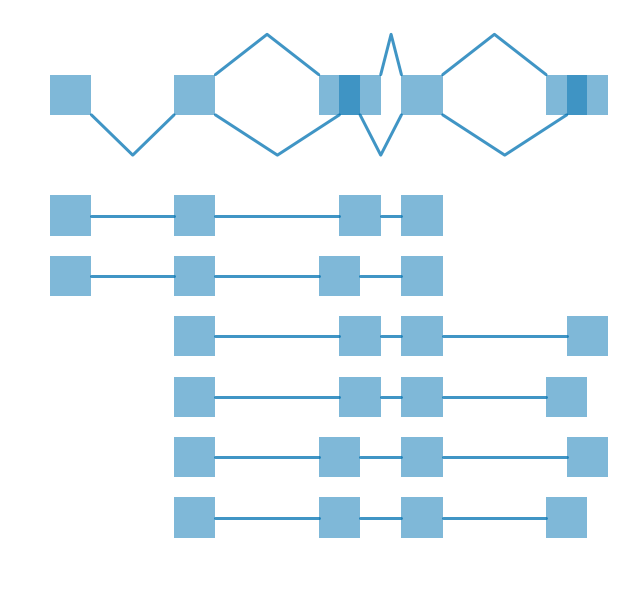

In [17]:
np.random.seed(15)
draw_g4_network(g4_networks.loc[26, 'graph'])
plt.savefig('g4_network.svg')
plt.show()

In [18]:
prot_motifs = []

def cds_pos_to_prot_pos(inv):
    start, end = inv
    start_in_prot, start_frame = divmod(start, 3)
    end_in_prot, end_frame = divmod(end, 3)
    if end_frame:
        end_in_prot += 1
    return (start_in_prot, end_in_prot), (start_frame, end_frame)


for seq, seq_g4s in zip(seqs, g4s):
    prot = str(Seq(seq).translate())
    hc_prot = np.array([hardcoded[aa] for aa in prot]).ravel()
    for name, start, end, ranges, strand in seq_g4s:
        (prot_start, prot_end), (start_frame, end_frame) = cds_pos_to_prot_pos((start, end))
        prot_ranges = []
        prot_frames = []
        for t in ranges:
            pr, pf = cds_pos_to_prot_pos(t)
            prot_ranges.append(pr)
            prot_frames.append(pf)
        prot_ranges = np.array(prot_ranges)
        cds_seq = seq[start:end]
        prot_seq = prot[prot_start: prot_end]
        prot_tetrads = [prot[i:j] for i, j in prot_ranges]
        tetrads_hardcoded = [hc_prot[i:j].all() for i, j in ranges]
        prot_loops = [prot[i:j] for i, j in zip(prot_ranges[:-1, 1], prot_ranges[1:, 0])]
        prot_motifs.append((name, start, end, strand,
                            prot_start, prot_end,
                            start_frame, end_frame,
                            cds_seq, prot_seq,
                            *prot_ranges[:, 0],
                            *prot_frames,
                            *tetrads_hardcoded,
                            *prot_tetrads, *prot_loops))


In [19]:
prot_motifs = pd.DataFrame(
    prot_motifs,
    columns=['transcript_id',
             'g4_start_cds', 'g4_end_cds', 'strand',
             'g4_start_prot', 'g4_end_prot',
             'g4_start_frame', 'g4_end_frame',
             'g4_seq_cds', 'g4_seq_prot',
             'tet1_start', 'tet2_start',
             'tet3_start', 'tet4_start',
             'tet1_frame', 'tet2_frame',
             'tet3_frame', 'tet4_frame',
             'tet1_hardcoded', 'tet2_hardcoded',
             'tet3_hardcoded', 'tet4_hardcoded',
             'tet1_seq_prot', 'tet2_seq_prot',
             'tet3_seq_prot', 'tet4_seq_prot',
             'loop1_seq_prot', 'loop2_seq_prot',
             'loop3_seq_prot']
)
prot_motifs['seq_len'] = prot_motifs.transcript_id.map(seq_lens)
prot_motifs['total_hc'] = prot_motifs[
    [x for x in prot_motifs.columns if x.endswith('hardcoded')]
].sum(1)
prot_motifs['g4_mid_cds'] = prot_motifs[['g4_start_cds', 'g4_end_cds']].sum(1) // 2
bins = []
for _, mid, length in prot_motifs[['g4_mid_cds', 'seq_len']].itertuples():
    x = np.linspace(0, length, 100)
    bins.append(np.searchsorted(x, mid))
prot_motifs['bin_idx'] = bins
prot_motifs.head()

,transcript_id,g4_start_cds,g4_end_cds,strand,g4_start_prot,g4_end_prot,g4_start_frame,g4_end_frame,g4_seq_cds,g4_seq_prot,...,tet2_seq_prot,tet3_seq_prot,tet4_seq_prot,loop1_seq_prot,loop2_seq_prot,loop3_seq_prot,seq_len,total_hc,g4_mid_cds,bin_idx
0,AT1G51370.2,163,184,+,54,62,1,1,GGCAATCGGTTCCTGGATTGG,WQSVPGLD,...,SV,G,LD,Q,P,,1041,2,173,17
1,AT1G50920.1,1232,1256,+,410,419,2,2,GGAAGAGGAGAATGGTGGAGCTGG,LEEENGGAG,...,EE,G,G,,N,GA,2016,2,1244,62
2,AT1G50920.1,1232,1250,+,410,417,2,2,GGAAGAGGAGAATGGTGG,LEEENGG,...,EE,G,G,,N,,2016,2,1241,61
3,AT1G50920.1,1238,1256,+,412,419,2,2,GGAGAATGGTGGAGCTGG,EENGGAG,...,G,G,G,N,,A,2016,3,1247,62
4,AT1G50920.1,1408,1424,+,469,475,1,2,GGATAAGGGAGGCTGG,GIREAG,...,R,EA,G,I,,,2016,1,1416,70


/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


7.72976848328 1.84689585154
0.0882835704236
0.0776635324591
17.2290596675 6.92518627722
0.273813549769
0.174386329361


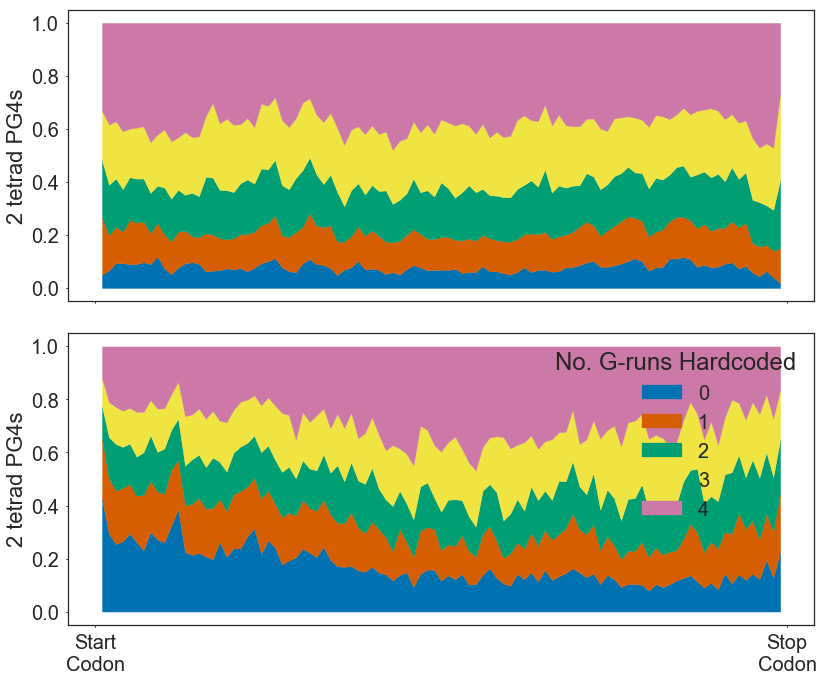

In [21]:
fig, axes = plt.subplots(figsize=(12, 10), nrows=2, sharex=True, sharey=True)
for i, strand in enumerate(('+', '-')):
    all_bins = [np.repeat(0, 100)]
    df_strand = prot_motifs[prot_motifs.strand == strand]
    axes[i].set_ylabel('2 tetrad PG4s')
    for j in range(0, 5):
        idx = df_strand[df_strand.total_hc == j].bin_idx
        bincount = np.bincount(idx, minlength=100)
        all_bins.append(bincount)
    cum_bins = np.cumsum(all_bins, axis=0)
    nhc = cum_bins[1] / cum_bins[-1] * 100
    print(np.nanmean(nhc), np.nanstd(nhc))
    first_10perc_nhc = cum_bins[1, :10].sum() / cum_bins[-1, :10].sum()
    print(first_10perc_nhc)
    perc_nhc = cum_bins[1, 10:].sum() / cum_bins[-1, 10:].sum()
    print(perc_nhc)
    for j in range(0, 5):
        axes[i].fill_between(np.arange(100),
                             cum_bins[j] / cum_bins[-1],
                             cum_bins[j + 1] / cum_bins[-1],
                             color=pal[j],
                             label=j)
axes[1].legend(title='No. G-runs Hardcoded')
axes[1].set_xticks([0, 100])
axes[1].set_xticklabels(['Start\nCodon', 'Stop\nCodon'])
plt.tight_layout()
plt.savefig('hardcoded_pg4s_metagene.svg')
plt.show()

In [22]:
x, c = np.unique(prot_motifs.total_hc, return_counts=True)
print(x, c / len(prot_motifs))

[0 1 2 3 4] [ 0.1230438   0.14769122  0.17471535  0.21265668  0.34189295]


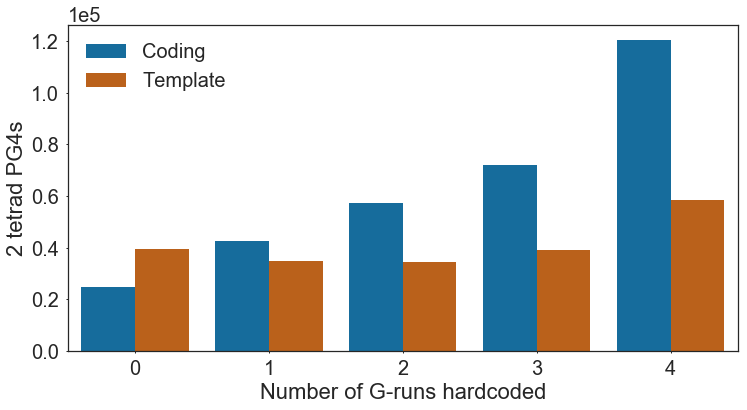

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(prot_motifs.total_hc,
              hue=prot_motifs.strand.map(
                  {'+': 'Coding', '-': 'Template'}),
              ax=ax)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel('Number of G-runs hardcoded')
ax.set_ylabel('2 tetrad PG4s')
ax.legend_.set_title('')
plt.savefig('cds_pg4_number_g_runs_hardcoded.svg')
plt.show()

In [24]:
prot_motifs['t_same'] = np.any([
    prot_motifs['tet{}_seq_prot'.format(x)] == prot_motifs['tet1_seq_prot']
    for x in (2, 3, 4)], axis=0)
prot_motifs['t_same'] = prot_motifs.t_same.map({True: 'Repetitive', False: 'Non-repetitive'})

In [25]:
tetrad_protein_sequences = pd.melt(
    prot_motifs,
    id_vars=['transcript_id', 'strand', 't_same'],
    value_vars=[x for x in prot_motifs.columns if x.startswith('tet') and x.endswith('seq_prot')],
    value_name='tet_protein_seq',
    var_name='tetrad'
)
tetrad_protein_sequences.head()

,transcript_id,strand,t_same,tetrad,tet_protein_seq
0,AT1G51370.2,+,Non-repetitive,tet1_seq_prot,W
1,AT1G50920.1,+,Non-repetitive,tet1_seq_prot,LE
2,AT1G50920.1,+,Non-repetitive,tet1_seq_prot,LE
3,AT1G50920.1,+,Non-repetitive,tet1_seq_prot,EE
4,AT1G50920.1,+,Repetitive,tet1_seq_prot,G


In [26]:
tetrad_protein_starts = pd.melt(
    prot_motifs,
    id_vars=[],
    value_vars=[x for x in prot_motifs.columns if x.startswith('tet') and x.endswith('start')],
    value_name='start',
    var_name='tetrad'
)

tetrad_hardcoded = pd.melt(
    prot_motifs,
    id_vars=[],
    value_vars=[x for x in prot_motifs.columns if x.startswith('tet') and x.endswith('hardcoded')],
    value_name='hardcoded',
    var_name='tetrad'
)
tetrad_hardcoded['hardcoded'] = tetrad_hardcoded.hardcoded.map({True: 'Hardcoded', False: 'Not hardcoded'})

tetrad_protein_frames = pd.melt(
    prot_motifs,
    id_vars=[],
    value_vars=[x for x in prot_motifs.columns if x.startswith('tet') and x.endswith('frame')],
    value_name='tet_protein_frame',
    var_name='tetrad'
)

tetrad_protein_sequences = pd.concat(
    [tetrad_protein_sequences, tetrad_hardcoded, tetrad_protein_starts, tetrad_protein_frames],
    axis=1,
    join='inner'
)

tetrad_protein_sequences = tetrad_protein_sequences.loc[
    :,~tetrad_protein_sequences.columns.duplicated()]

tetrad_protein_sequences['tetrad'] = tetrad_protein_sequences.tetrad.str.extract('(\d)')

tetrad_protein_sequences = (tetrad_protein_sequences.sort_values(by=['transcript_id', 'start', 't_same'])
                                                    .drop_duplicates(subset=['transcript_id', 'start'],
                                                                     keep='first'))

tetrad_protein_sequences.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,transcript_id,strand,t_same,tetrad,tet_protein_seq,hardcoded,start,tet_protein_frame
58798,AT1G01010.1,+,Non-repetitive,1,R,Not hardcoded,78,"(1, 0)"
581368,AT1G01010.1,+,Non-repetitive,2,TV,Not hardcoded,80,"(2, 1)"
1103938,AT1G01010.1,+,Non-repetitive,3,G,Hardcoded,83,"(0, 2)"
1626508,AT1G01010.1,+,Non-repetitive,4,W,Hardcoded,85,"(1, 0)"
58799,AT1G01010.1,-,Non-repetitive,1,IH,Not hardcoded,132,"(2, 1)"


[(0, 2) (1, 0) (2, 1)] [ 46.26979673  17.13040903  36.59979424]
[(0, 2) (1, 0) (2, 1)] [ 48.46672985  27.34379472  24.18947543]


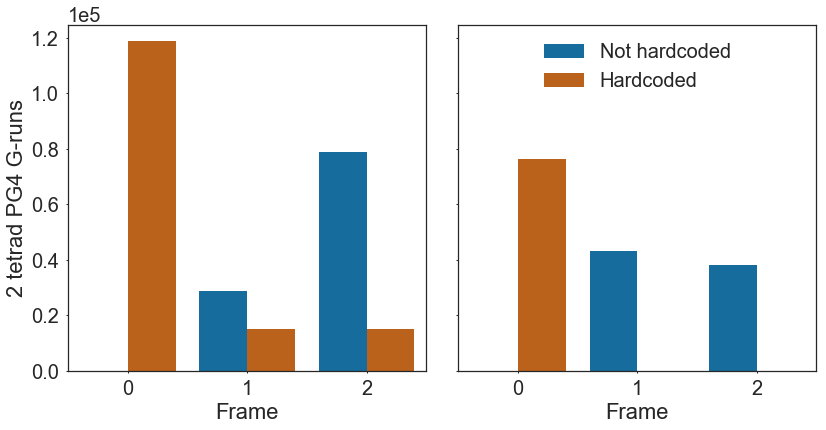

In [27]:
fig, axes = plt.subplots(figsize=(12, 6.5), ncols=2, sharey=True)

for i, strand in enumerate(('+', '-')):
    df = tetrad_protein_sequences[tetrad_protein_sequences.strand == strand]
    sns.countplot(
        np.array(df.tet_protein_frame.tolist())[:, 0],
        hue=df.hardcoded,
        ax=axes[i],
    )
    x, c = np.unique(df.tet_protein_frame, return_counts=True)
    print(x, c / len(df) * 100)
axes[0].legend_.remove()
axes[1].legend_.set_title('')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].set_ylabel('2 tetrad PG4 G-runs')
axes[1].set_ylabel('')
axes[0].set_xlabel('Frame')
axes[1].set_xlabel('Frame')
plt.tight_layout()
plt.savefig('cds_pg4_frame.svg')
plt.show()

0.579545454545
0.507887517147
0.484667298506
0.59894220169


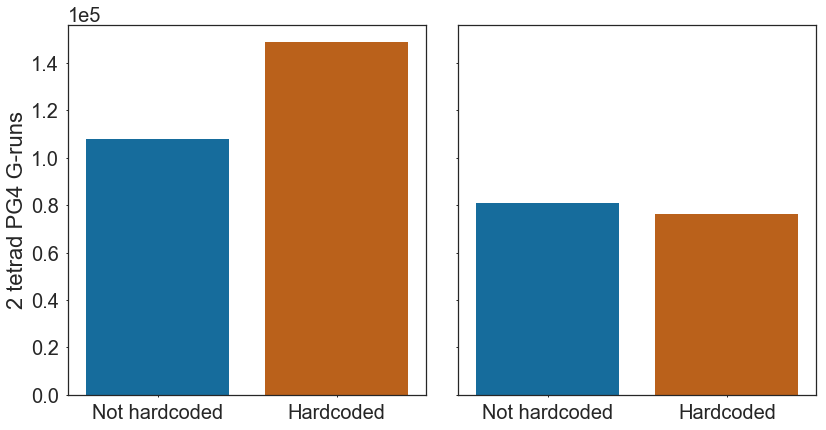

In [28]:
fig, axes = plt.subplots(figsize=(12, 6.5), ncols=2, sharey=True)

for i, strand in enumerate(('+', '-')):
    df = tetrad_protein_sequences[tetrad_protein_sequences.strand == strand].copy()
    print(sum(df.hardcoded == 'Hardcoded') / len(df))
    df_h = df[df.hardcoded == 'Hardcoded']
    print(sum(df_h.t_same == 'Repetitive') / len(df_h))
    sns.countplot(
        x='hardcoded',
        data=df,
        ax=axes[i]
    )
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].set_ylabel('2 tetrad PG4 G-runs')
axes[1].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.tight_layout()
plt.show()

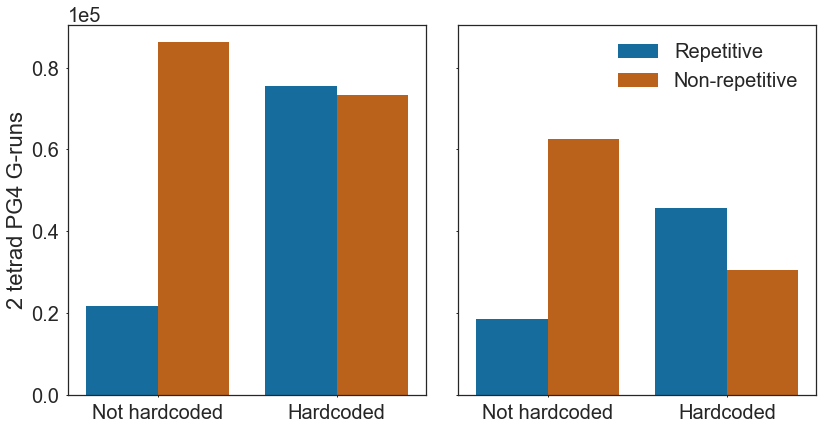

In [29]:
fig, axes = plt.subplots(figsize=(12, 6.5), ncols=2, sharey=True)

for i, strand in enumerate(('+', '-')):
    df = tetrad_protein_sequences[tetrad_protein_sequences.strand == strand].copy()
    top = [x[0] for x in Counter(df.tet_protein_seq).most_common(10)]
    df.loc[~df.tet_protein_seq.isin(top), 'tet_protein_seq'] = 'Other'
    sns.countplot(
        x='hardcoded',
        hue='t_same',
        hue_order=['Repetitive', 'Non-repetitive'],
        data=df,
        ax=axes[i]
    )
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].legend_.remove()
axes[1].legend_.set_title('')
axes[0].set_ylabel('2 tetrad PG4 G-runs')
axes[1].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.tight_layout()
plt.savefig('cds_pg4_hardcoded_vs_repetitive.svg')
plt.show()

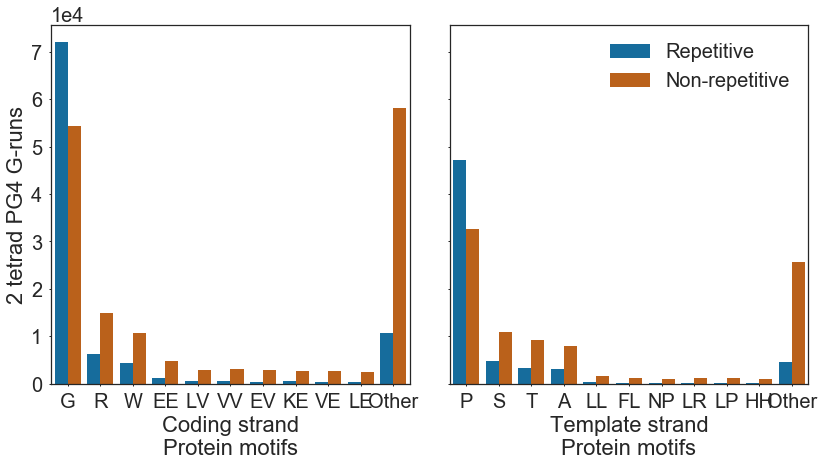

In [30]:
fig, axes = plt.subplots(figsize=(12, 7), ncols=2, sharey=True)

for i, strand in enumerate(('+', '-')):
    df = tetrad_protein_sequences[tetrad_protein_sequences.strand == strand].copy()
    top = [x[0] for x in Counter(df.tet_protein_seq).most_common(10)]
    df.loc[~df.tet_protein_seq.isin(top), 'tet_protein_seq'] = 'Other'
    sns.countplot(
        x='tet_protein_seq',
        hue='t_same',
        data=df,
        order=top + ['Other'],
        hue_order=['Repetitive', 'Non-repetitive'],
        ax=axes[i]
    )
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].set_ylabel('2 tetrad PG4 G-runs')
axes[0].legend_.remove()
axes[1].legend_.set_title('')
axes[1].set_ylabel('')
axes[0].set_xlabel('Coding strand\nProtein motifs')
axes[1].set_xlabel('Template strand\nProtein motifs')
plt.tight_layout()
plt.savefig('cds_pg4_protein_motifs_by_repetitive.svg')
plt.show()

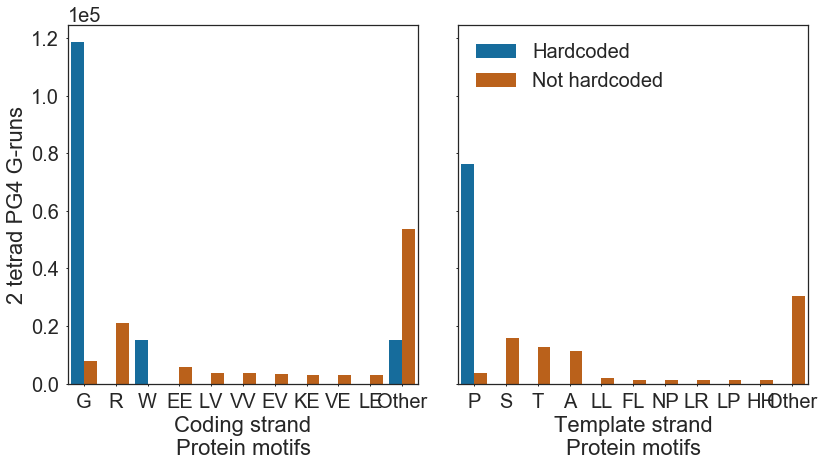

In [31]:
fig, axes = plt.subplots(figsize=(12, 7), ncols=2, sharey=True)
for i, strand in enumerate(('+', '-')):
    df = tetrad_protein_sequences[tetrad_protein_sequences.strand == strand].copy()
    top = [x[0] for x in Counter(df.tet_protein_seq).most_common(10)]
    df.loc[~df.tet_protein_seq.isin(top), 'tet_protein_seq'] = 'Other'
    sns.countplot(
        x='tet_protein_seq',
        hue='hardcoded',
        data=df,
        order=top + ['Other'],
        hue_order=['Hardcoded', 'Not hardcoded'],
        ax=axes[i]
    )
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].set_ylabel('2 tetrad PG4 G-runs')
axes[0].legend_.remove()
axes[1].legend_.set_title('')
axes[1].set_ylabel('')
axes[0].set_xlabel('Coding strand\nProtein motifs')
axes[1].set_xlabel('Template strand\nProtein motifs')
plt.tight_layout()
plt.savefig('cds_pg4_protein_motifs_by_hardcoded.svg')
plt.show()

In [32]:
!wget http://gtrnadb.ucsc.edu/GtRNAdb2/genomes/eukaryota/Athal10/araTha1-tRNAs.tar.gz

--2018-09-03 14:48:45--  http://gtrnadb.ucsc.edu/GtRNAdb2/genomes/eukaryota/Athal10/araTha1-tRNAs.tar.gz
Resolving gtrnadb.ucsc.edu (gtrnadb.ucsc.edu)... 128.114.49.96
Connecting to gtrnadb.ucsc.edu (gtrnadb.ucsc.edu)|128.114.49.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74729 (73K) [application/x-gzip]
Saving to: ‘araTha1-tRNAs.tar.gz’

araTha1-tRNAs.tar.g 100%[===================>]  72.98K   161KB/s    in 0.5s    

2018-09-03 14:48:46 (161 KB/s) - ‘araTha1-tRNAs.tar.gz’ saved [74729/74729]



In [36]:
%%bash
tar zxvf araTha1-tRNAs.tar.gz

araTha1-tRNAs.out
araTha1-tRNAs.ss.sort
araTha1-tRNAs.bed
araTha1-tRNAs.fa


In [13]:
from tAI.tAI import tAI

In [212]:
at_tai = pd.DataFrame(
    np.exp(tAI.from_gtRNAdb('araTha1-tRNAs.bed', bacteria=False).weights).rename('tai')
)
at_tai.head()

,tai
CCT,0.192771
TTC,0.253012
TTA,0.072289
ATT,0.219036
GTC,0.154217


In [213]:
%%cython
import numpy as np
cimport numpy as np
from collections import Counter

SYN_CODON = {
    'A': ['GCA', 'GCC', 'GCG', 'GCT'],
    'C': ['TGT', 'TGC'],
    'D': ['GAT', 'GAC'],
    'E': ['GAG', 'GAA'],
    'F': ['TTT', 'TTC'],
    'G': ['GGT', 'GGG', 'GGA', 'GGC'],
    'H': ['CAT', 'CAC'],
    'I': ['ATC', 'ATA', 'ATT'],
    'K': ['AAG', 'AAA'],
    'L': ['TTA', 'TTG', 'CTC', 'CTT', 'CTG', 'CTA'],
    'M': ['ATG'],
    'N': ['AAC', 'AAT'],
    'P': ['CCT', 'CCG', 'CCA', 'CCC'],
    'Q': ['CAA', 'CAG'],
    'R': ['CGA', 'CGC', 'CGG', 'CGT', 'AGG', 'AGA'],
    'S': ['TCT', 'TCG', 'TCA', 'TCC', 'AGC', 'AGT'],
    'T': ['ACC', 'ACA', 'ACG', 'ACT'],
    'V': ['GTA', 'GTC', 'GTG', 'GTT'],
    'W': ['TGG'],
    '*': ['TAG', 'TGA', 'TAA'],
    'Y': ['TAT', 'TAC'],
}

TRANSLATION_TABLE = {
    'AGT': 'S', 'ATT': 'I', 'CCC': 'P', 'TGC': 'C', 'CTT': 'L',
    'GCT': 'A', 'GGG': 'G', 'ATG': 'M', 'CCA': 'P', 'GAG': 'E',
    'TGA': '*', 'TAG': '*', 'CAG': 'Q', 'CAC': 'H', 'GTC': 'V',
    'GAA': 'E', 'CAT': 'H', 'GGC': 'G', 'CTG': 'L', 'GGA': 'G',
    'TTA': 'L', 'TAT': 'Y', 'CTC': 'L', 'TAC': 'Y', 'TAA': '*',
    'ATC': 'I', 'TCC': 'S', 'GTT': 'V', 'GCA': 'A', 'AAA': 'K',
    'TCA': 'S', 'ATA': 'I', 'CTA': 'L', 'AGC': 'S', 'TTC': 'F',
    'GCG': 'A', 'GGT': 'G', 'GAT': 'D', 'CGA': 'R', 'ACA': 'T',
    'AAC': 'N', 'ACG': 'T', 'CGG': 'R', 'TGT': 'C', 'AGA': 'R',
    'GTG': 'V', 'TGG': 'W', 'TCT': 'S', 'CAA': 'Q', 'ACT': 'T',
    'TTG': 'L', 'AAG': 'K', 'AGG': 'R', 'GAC': 'D', 'CGT': 'R',
    'TCG': 'S', 'CGC': 'R', 'GTA': 'V', 'CCT': 'P', 'TTT': 'F',
    'CCG': 'P', 'AAT': 'N', 'GCC': 'A', 'ACC': 'T',
}

def get_seq_slices(seq_length, n_chunks, seq_type='cds'):
    if seq_type == 'cds':
        seq_length = seq_length // 3
        factor = 3
    elif seq_type == 'protein':
        factor = 1
    else:
        raise TypeError()
    cs, r = divmod(seq_length, n_chunks)
    cs *= factor
    chunk_sizes = [cs + factor] * r + [cs] * (n_chunks - r)
    offset = 0
    slices = []
    for cs in chunk_sizes:
        slices.append((offset, offset + cs))
        offset += cs
    return slices


def chunkseq_start(seq, chunksize, n_chunks):
    slen = len(seq)
    tot_chunks = int(np.ceil(slen / chunksize))
    maxsize = min(n_chunks, tot_chunks)
    r = np.arange(0, chunksize * maxsize + 1, chunksize)
    seqs = [seq[i:j] for i, j in zip(r[:-1], r[1:])]
    for i in range(n_chunks - tot_chunks):
        seqs.append('')
    return seqs

def create_start_abs_chunked_codon_table(seqs, chunksize=60, n_chunks=5):
    codon_tables = []
    seq_slices = zip(*[chunkseq_start(seq, chunksize, n_chunks) for seq in seqs])
    for subseqs in seq_slices:
        codon_tables.append(create_codon_table(subseqs))
    return codon_tables


def create_chunked_codon_table(seqs, n_chunks=5):
    seq_slices = zip(*[get_seq_slices(len(seq), n_chunks) for seq in seqs])
    codon_tables = []
    for chunk_sizes in seq_slices:
        sub_seqs = [seq[slice(*slic)] for seq, slic in zip(seqs, chunk_sizes)]
        codon_tables.append(create_codon_table(sub_seqs))
    return codon_tables


def create_codon_table(seqs):
    codon_count = Counter()
    for seq in seqs:
        if not len(seq) % 3:
            for i in range(0, len(seq) - 2, 3):
                codon_count[seq[i: i + 3]] += 1
    codon_table = {}
    for aa, codons in SYN_CODON.items():
        codon_freqs = np.array([codon_count[c] for c in codons])
        s = codon_freqs.sum()
        s = s if s else 1
        codon_freqs = codon_freqs / s
        for cdn, freq in zip(codons, codon_freqs):
            codon_table[cdn] = freq
    return codon_table

In [149]:
seqs = []
seq_ids = []
codon_tables = []
with open('/home/matthew/Documents/genomes/tair10/fasta/tair10_cds.fa') as cds:
    for record in parse(cds, 'fasta'):
        if len(str(record.seq)) % 3:
            continue
        seq = str(record.seq)
        seqs.append(seq[:-3])
codon_table = create_codon_table(seqs)
chunked_codon_table = create_chunked_codon_table(seqs, 25)
chunked_codon_table = pd.concat([pd.Series(x) for x in chunked_codon_table], axis=1)
chunked_codon_table_start = create_start_abs_chunked_codon_table(seqs, 30, 10)
chunked_codon_table_start = pd.concat([pd.Series(x) for x in chunked_codon_table_start], axis=1)


In [214]:
tai_nc = at_tai.join(chunked_codon_table).drop(['ATG', 'TGA', 'TAA', 'TAG'], errors='ignore')
tai_nc.head()

,tai,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
CCT,0.192771,0.355103,0.390047,0.409224,0.420069,0.421065,0.425960,0.421530,0.413649,0.411152,...,0.380632,0.376354,0.368143,0.361816,0.355425,0.347584,0.335939,0.336007,0.349812,0.379210
TTC,0.253012,0.531772,0.541799,0.524320,0.496719,0.481470,0.461796,0.450362,0.450034,0.436047,...,0.450356,0.453185,0.471219,0.475819,0.479686,0.477852,0.474694,0.479833,0.473645,0.490836
TTA,0.072289,0.145925,0.136733,0.132237,0.132978,0.134163,0.140108,0.139016,0.140478,0.141788,...,0.144191,0.143685,0.142598,0.144056,0.138166,0.139322,0.137842,0.135608,0.131519,0.134526
ATT,0.219036,0.386693,0.388485,0.401125,0.417891,0.429354,0.437968,0.440082,0.439840,0.430715,...,0.410256,0.406839,0.403224,0.398074,0.395472,0.383961,0.384566,0.384881,0.389645,0.400779
GTC,0.154217,0.192531,0.226782,0.220676,0.211975,0.196453,0.189989,0.191292,0.176434,0.172507,...,0.174613,0.178416,0.175135,0.176551,0.176260,0.171678,0.162853,0.167678,0.174143,0.202162


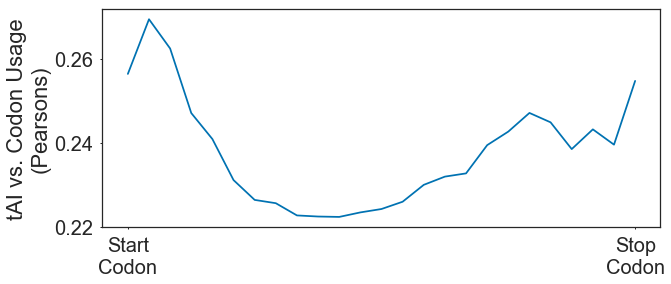

In [217]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(tai_nc.corr(method='pearson')['tai'][1:])
ax.set_ylabel('tAI vs. Codon Usage\n(Pearsons)')
ax.set_xticks([0, 24])
ax.set_xticklabels(['Start\nCodon', 'Stop\nCodon'])
plt.savefig('tai_codon_usage_metagene.svg')
plt.show()

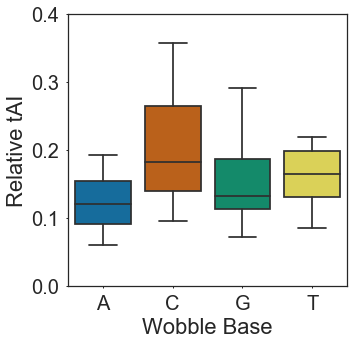

In [218]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    x=tai_nc.index.str[2],
    y=tai_nc.tai,
    fliersize=0,
    order=['A', 'C', 'G', 'T'],
)
ax.set_ylim(0, 0.4)
ax.set_xlabel('Wobble Base')
ax.set_ylabel('Relative tAI')
plt.savefig('./wobble_pos_tai_boxplot.svg')
plt.show()

In [237]:
def get_seq_codon_opt(seq, n_codons=100, rev=False):
    if rev == True:
        seq = seq[::-1]
    codon_opt = []
    for i in range(0, min(len(seq) - 2, 3 * n_codons - 2), 3):
        try:
            codon_opt.append(at_tai.loc[seq[i: i + 3], 'tai'])
        except KeyError:
            codon_opt.append(np.nan)
    codon_opt = np.array(codon_opt)
    filled = np.full(n_codons, np.nan)
    filled[:len(codon_opt)] = codon_opt
    if rev:
        filled = filled[::-1]
    return filled

In [243]:
codon_opt = [get_seq_codon_opt(seq, 100) for seq in seqs]
codon_opt = np.nanmean(codon_opt, axis=0)[1:]
codon_opt_end = [get_seq_codon_opt(seq, 100, True) for seq in seqs]
codon_opt_end = np.nanmean(codon_opt_end, axis=0)

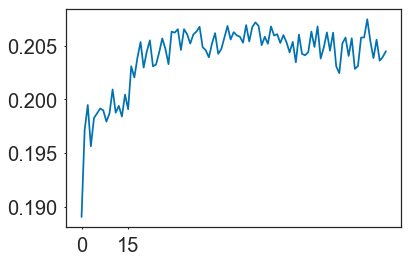

In [259]:
fig, ax = plt.subplots()
ax.plot(codon_opt)
ax.set_xticks([0, 15])

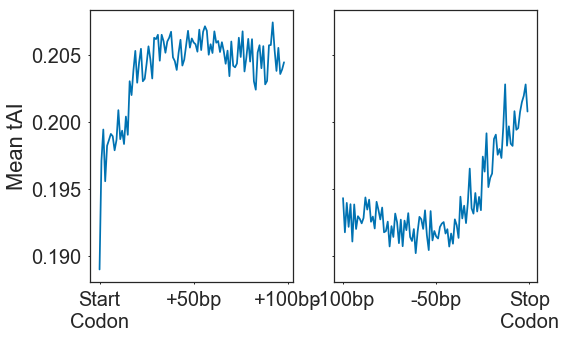

In [261]:
fig, ax = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)
ax[0].plot(codon_opt)
ax[1].plot(codon_opt_end)
ax[0].set_ylabel('Mean tAI')
ax[0].set_xticks([0, 50, 100])
ax[0].set_xticklabels(['Start\nCodon', '+50bp', '+100bp'])

ax[1].set_xticks([0, 50, 100])
ax[1].set_xticklabels(['-100bp', '-50bp', 'Stop\nCodon'])
plt.savefig('tAI_positions.svg')
plt.show()